In [17]:
# Setup
import os, warnings, math, pickle, numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

warnings.filterwarnings('ignore')

DATASET_PATH = "./house_data.csv"
TARGET = "Price"
NUM_FEATURES = ["Id", "Area","Bedrooms","Bathrooms","Floors","YearBuilt"]
CAT_FEATURES = ["Location","Condition","Garage"]
RANDOM_STATE = 42

os.makedirs("../models", exist_ok=True)

In [18]:
# Load Data
import pandas as pd, os
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(DATASET_PATH)

df = pd.read_csv(DATASET_PATH)
print(df.shape)
df.head()

(2000, 10)


,Id,Area,Bedrooms,Bathrooms,Floors,YearBuilt,Location,Condition,Garage,Price
0,1,1360,5,4,3,1970,Downtown,Excellent,No,149919
1,2,4272,5,4,3,1958,Downtown,Excellent,No,424998
2,3,3592,2,2,3,1938,Downtown,Good,No,266746
3,4,966,4,2,2,1902,Suburban,Fair,Yes,244020
4,5,4926,1,4,2,1975,Downtown,Fair,Yes,636056


In [20]:
# Basic Overview
display(df.describe(include='all').transpose())
print("\nMissing values per column:")
print(df.isna().sum())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,2000.0,NaN,NaN,NaN,1000.5,577.494589,1.0,500.75,1000.5,1500.25,2000.0
Area,2000.0,NaN,NaN,NaN,2786.2095,1295.146799,501.0,1653.0,2833.0,3887.5,4999.0
Bedrooms,2000.0,NaN,NaN,NaN,3.0035,1.424606,1.0,2.0,3.0,4.0,5.0
Bathrooms,2000.0,NaN,NaN,NaN,2.5525,1.10899,1.0,2.0,3.0,4.0,4.0
Floors,2000.0,NaN,NaN,NaN,1.9935,0.809188,1.0,1.0,2.0,3.0,3.0
YearBuilt,2000.0,NaN,NaN,NaN,1961.446,35.926695,1900.0,1930.0,1961.0,1993.0,2023.0
Location,2000,4,Downtown,558,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Condition,2000,4,Fair,521,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Garage,2000,2,No,1038,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,2000.0,NaN,NaN,NaN,537676.855,276428.845719,50005.0,300098.0,539254.0,780086.0,999656.0



Missing values per column:
Id           0
Area         0
Bedrooms     0
Bathrooms    0
Floors       0
YearBuilt    0
Location     0
Condition    0
Garage       0
Price        0
dtype: int64


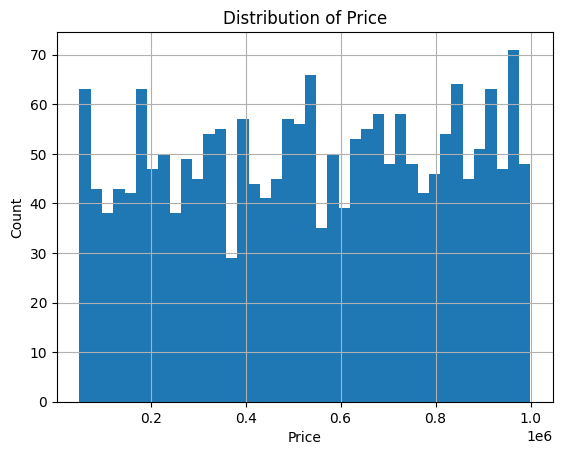

In [21]:

# EDA — Target distribution
plt.figure()
df[TARGET].hist(bins=40)
plt.title("Distribution of Price")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

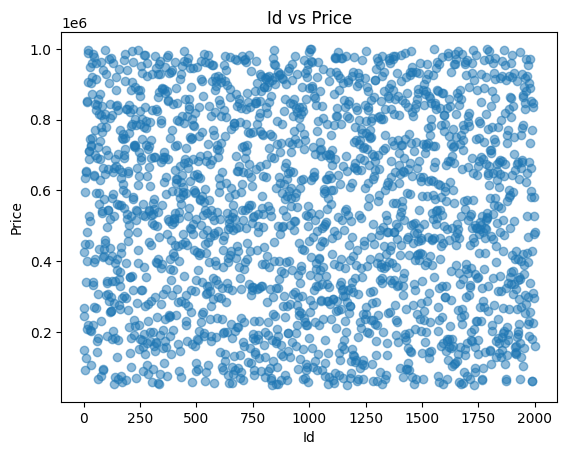

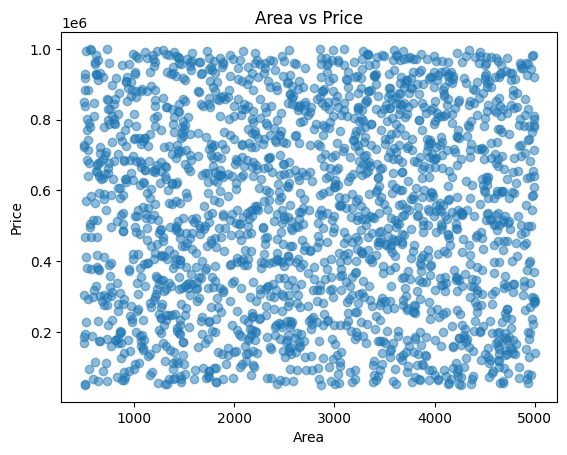

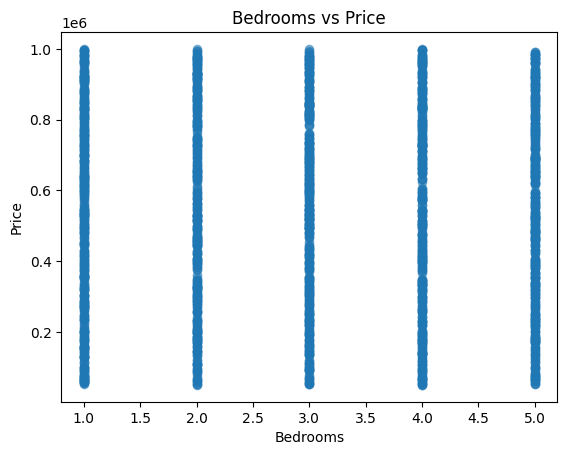

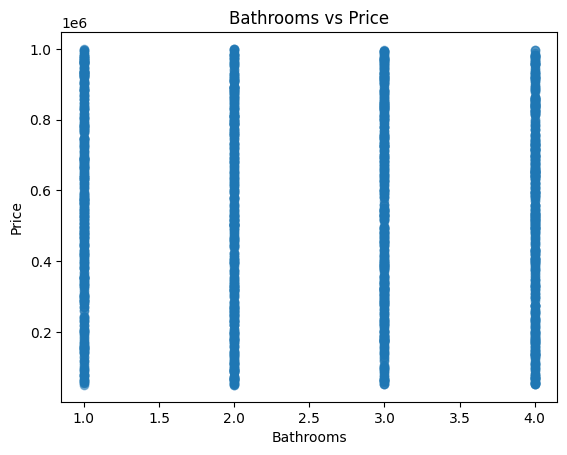

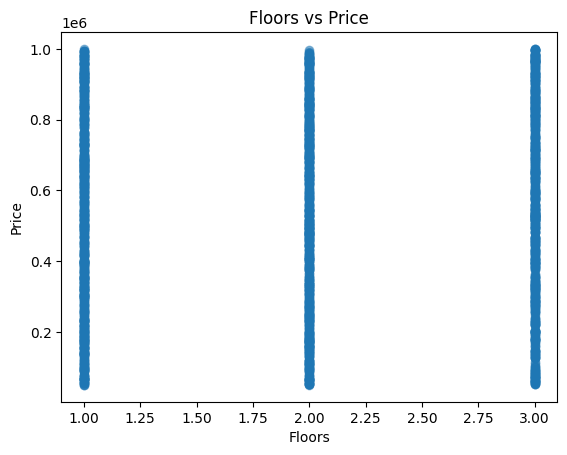

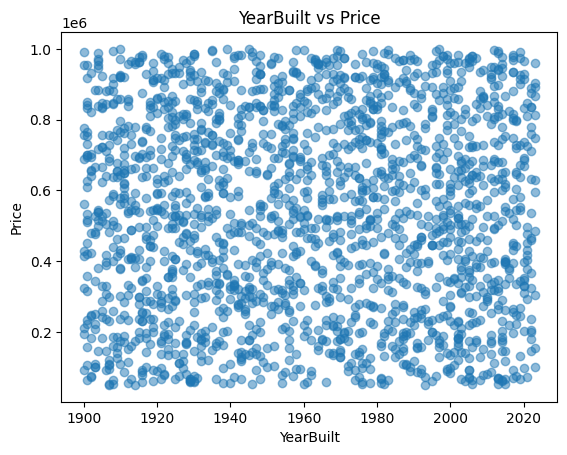

In [22]:
# EDA — Scatter plots for numeric features vs target
for col in [c for c in NUM_FEATURES if c in df.columns]:
    plt.figure()
    plt.scatter(df[col], df[TARGET], alpha=0.5)
    plt.title(f"{col} vs {TARGET}")
    plt.xlabel(col)
    plt.ylabel(TARGET)
    plt.show()

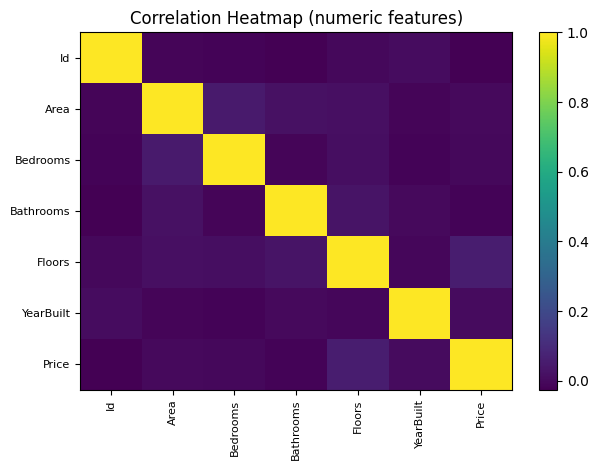

Price        1.000000
Floors       0.055890
YearBuilt    0.004845
Area         0.001542
Bedrooms    -0.003471
Bathrooms   -0.015737
Id          -0.025643
Name: Price, dtype: float64

In [23]:
# Correlation heatmap (numeric only)
corr = df[NUM_FEATURES + [TARGET]].corr()
plt.figure()
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.title("Correlation Heatmap (numeric features)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=8)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=8)
plt.tight_layout()
plt.show()

corr[TARGET].sort_values(ascending=False)

In [ ]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor
import pickle

# Config
RANDOM_STATE = 42
TARGET = "Price"
DROP = ["Id"]

DATASET_PATH = "./house_data.csv"
df = pd.read_csv(DATASET_PATH)

# Drop unwanted columns
df = df.drop(columns=[c for c in DROP if c in df.columns])

# Prepare features + target
y = df[TARGET]
X = df.drop(columns=[TARGET])

# Auto-detect numeric and categorical features
num_features = X.select_dtypes(include=['number']).columns.tolist()
cat_features = X.select_dtypes(exclude=['number']).columns.tolist()

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

# Ordinal Encoding for ordered categorical features
ordinal_transformers = []

# Corrected ordinal orders for monotonic price effect
if "Condition" in X.columns:
    condition_order = [["Good", "Excellent"]]
    ordinal_transformers.append(("Condition", OrdinalEncoder(categories=condition_order, handle_unknown="use_encoded_value", unknown_value=-1), ["Condition"]))
    cat_features.remove("Condition")

if "location" in X.columns:
    location_order = [["Rural","Urban"]]
    ordinal_transformers.append(("location", OrdinalEncoder(categories=location_order), ["location"]))

if "garage" in X.columns:
    # None < Carport < Garage
    garage_order = [["None", "Carport", "Garage"]]
    ordinal_transformers.append(("garage", OrdinalEncoder(categories=garage_order), ["garage"]))
    cat_features.remove("garage")

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ] + ordinal_transformers
)

# Fit preprocessor to get feature names
preprocessor.fit(X)
feature_names = preprocessor.get_feature_names_out()

# Build monotonic constraints: all numeric features and all ordinal features get +1
monotonic_cst = []
for f in feature_names:
    f_lower = f.lower()
    # Numeric features
    if ("area" in f_lower or "bedrooms" in f_lower or "bathrooms" in f_lower or "floors" in f_lower or "yearbuilt" in f_lower):
        monotonic_cst.append(1)
    # Ordinal features (Condition, location, garage)
    elif ("condition" in f_lower or "location" in f_lower or "garage" in f_lower):
        monotonic_cst.append(1)
    else:
        monotonic_cst.append(0)

print("\nMonotonic constraints length:", len(monotonic_cst))
print("Feature names:", feature_names)
print("Constraints:", monotonic_cst)

# Pipeline with model
regressor = HistGradientBoostingRegressor(
    random_state=RANDOM_STATE,
    monotonic_cst=monotonic_cst
)

model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", regressor)
])

# Cross-validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# Baseline cross-validation metrics
rmse_scores = -cross_val_score(model_pipeline, X, y, cv=kf, scoring="neg_root_mean_squared_error")
mae_scores = -cross_val_score(model_pipeline, X, y, cv=kf, scoring="neg_mean_absolute_error")
r2_scores = cross_val_score(model_pipeline, X, y, cv=kf, scoring="r2")

print("\n📊 Cross-validation results:")
print("RMSE per fold:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("MAE per fold:", mae_scores)
print("Mean MAE:", mae_scores.mean())
print("R² per fold:", r2_scores)
print("Mean R²:", r2_scores.mean())

# Hyperparameter tuning
param_grid = {
    "regressor__max_depth": [None, 10, 20],
    "regressor__learning_rate": [0.05, 0.1, 0.2],
    "regressor__max_iter": [200, 500]
}

grid = GridSearchCV(
    model_pipeline,
    param_grid,
    cv=kf,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid.fit(X, y)

print("\n✅ Best parameters:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)

# Save full pipeline (preprocessing + best model)
best_pipeline = grid.best_estimator_

with open("house_model.pkl", "wb") as f:
    pickle.dump(best_pipeline, f)

print("\n💾 Full pipeline saved to house_model.pkl (preprocessing + model)")

Numeric features: ['Area', 'Bedrooms', 'Bathrooms', 'Floors', 'YearBuilt']
Categorical features: ['Location', 'Condition', 'Garage']

Monotonic constraints length: 12
Feature names: ['num__Area' 'num__Bedrooms' 'num__Bathrooms' 'num__Floors'
 'num__YearBuilt' 'cat__Location_Downtown' 'cat__Location_Rural'
 'cat__Location_Suburban' 'cat__Location_Urban' 'cat__Garage_No'
 'cat__Garage_Yes' 'Condition__Condition']
Constraints: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

📊 Cross-validation results:
RMSE per fold: [288591.25986353 280514.00139537 287214.93852085 282741.24561893
 284007.91540401 282522.18177166 291365.87124414 277634.24445967
 283547.96613138 264606.01190951]
Mean RMSE: 282274.5636319043
MAE per fold: [249950.02522003 243712.38997725 250686.4839172  241175.62587499
 240702.80494491 238663.45150805 257781.93047049 235542.03121452
 244499.61946134 223714.33326758]
Mean MAE: 242642.86958563607
R² per fold: [-0.0307894  -0.07138015 -0.03498644 -0.07252867 -0.06597295 -0.06619884
 -0.0

In [35]:
import pickle

with open("house_model.pkl", "rb") as f:
    model = pickle.load(f)

# If it’s a pipeline, access preprocessing step
preprocessor = model.named_steps['preprocessor']

# Numeric + categorical columns
print("Numeric features:", preprocessor.transformers_[0][2])
print("Categorical features:", preprocessor.transformers_[1][2])


Numeric features: ['Area', 'Bedrooms', 'Bathrooms', 'Floors', 'YearBuilt']
Categorical features: ['Location', 'Garage']


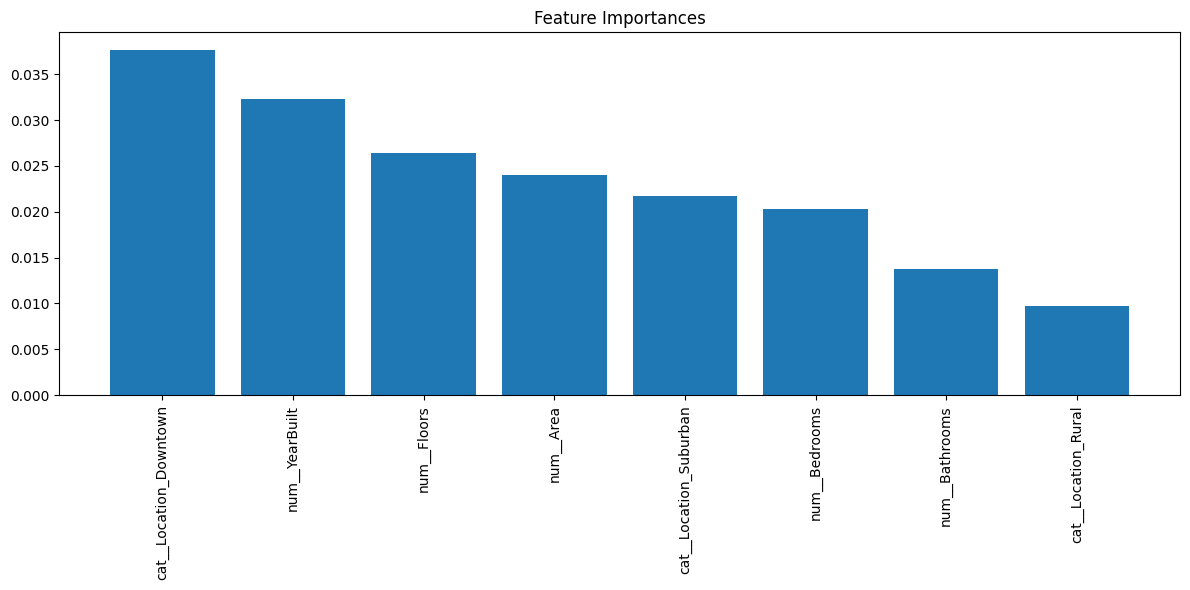

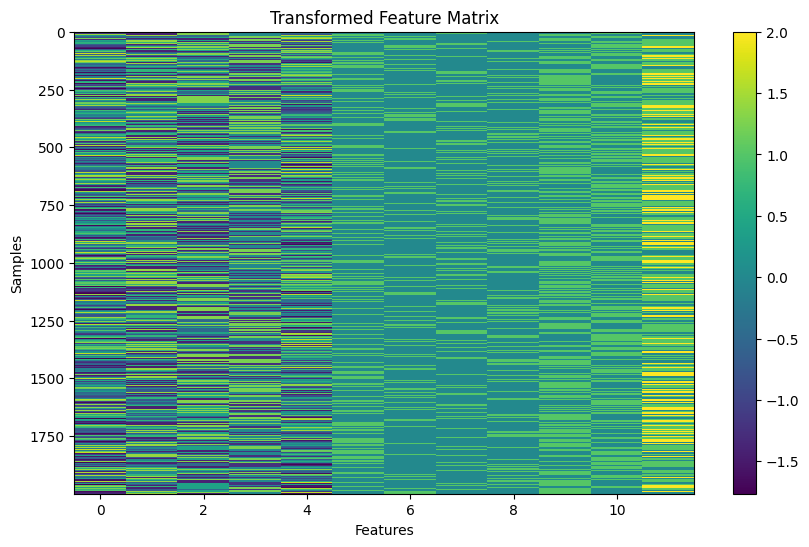

In [36]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance

# Load the trained pipeline
with open("house_model.pkl", "rb") as f:
    model = pickle.load(f)

# Access preprocessor and regressor
preprocessor = model.named_steps['preprocessor']
regressor = model.named_steps['regressor']

# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Visualize feature importances
result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
importances = result.importances_mean
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Visualize the transformed feature matrix
X_transformed = preprocessor.transform(X)
plt.figure(figsize=(10, 6))
plt.imshow(X_transformed, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.title("Transformed Feature Matrix")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()